### Galactic Plane Footprint metrics ###

Let's have a look at these metrics and see how they're varying across different simulations.

In [2]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
import rubin_sim.maf as maf

In [3]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values
summary_source = 'summary_2022_06_12.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metrics_source = 'metric_sets.json'
metric_sets = maf.get_metric_sets(metrics_source)

In [4]:
msets = list(metric_sets.groupby('metric set').first().index)
gp = [m for m in msets if m.startswith('GP')]
gp

['GP filters', 'GP footprint', 'GP season', 'GP visit']

In [5]:
metric_sets.loc[gp].head()

metric  \
metric set metric                                                                                                  
GP filters Mean GalplaneTimePerFilter_combined_map_u  Heal...  Mean GalplaneTimePerFilter_combined_map_u  Hea...   
           Mean GalplaneTimePerFilter_combined_map_g  Heal...  Mean GalplaneTimePerFilter_combined_map_g  Hea...   
           Mean GalplaneTimePerFilter_combined_map_r  Heal...  Mean GalplaneTimePerFilter_combined_map_r  Hea...   
           Mean GalplaneTimePerFilter_combined_map_i  Heal...  Mean GalplaneTimePerFilter_combined_map_i  Hea...   
           Mean GalplaneTimePerFilter_combined_map_z  Heal...  Mean GalplaneTimePerFilter_combined_map_z  Hea...   

                                                                                              short_name  \
metric set metric                                                                                          
GP filters Mean GalplaneTimePerFilter_combined_map_u  Heal...  Mean GalplaneTimePerFilter_combined_map_u   
           Mean GalplaneTimePerFilter_combined_map_g  Heal...  Mean GalplaneTimePerFilter_combined_map_g   
           Mean GalplaneTimePerFilter_combined_map_r  Heal...  Mean GalplaneTimePerFilter_combined_map_r   
           Mean GalplaneTimePerFilter_combined_map_i  Heal...  Mean GalplaneTimePerFilter_combined_map_i   
           Mean GalplaneTimePerFilter_combined_map_z  Heal...  Mean GalplaneTimePerFilter_combined_map_z   

                                                              style  invert  \
metric set metric                                                             
GP filters Mean GalplaneTimePerFilter_combined_map_u  Heal...    c-   False   
           Mean GalplaneTimePerFilter_combined_map_g  Heal...    g-   False   
           Mean GalplaneTimePerFilter_combined_map_r  Heal...    y-   False   
           Mean GalplaneTimePerFilter_combined_map_i  Heal...    r-   False   
           Mean GalplaneTimePerFilter_combined_map_z  Heal...    m-   False   

                                                                 mag  
metric set metric                                                     
GP filters Mean GalplaneTimePerFilter_combined_map_u  Heal...  False  
           Mean GalplaneTimePerFilter_combined_map_g  Heal...  False  
           Mean GalplaneTimePerFilter_combined_map_r  Heal...  False  
           Mean GalplaneTimePerFilter_combined_map_i  Heal...  False  
           Mean GalplaneTimePerFilter_combined_map_z  Heal...  False

In the high-level metric set groups above, I've only pulled up the combined_map versions of the summary stats. The individual science maps are still in the summary file, but this is intended to reduce clutter and highlight trends in the top-level results. 

In [6]:
# These metrics compare results to the galactic plane priority maps; let's look at the maps
s = maf.HealpixSlicer(nside=64)
galmap = maf.GalacticPlanePriorityMap()
slicePoints = galmap.run(s.slicePoints)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Read galplane priority map from /Users/lynnej/rubin_sim_data/maps/GalacticPlanePriorityMaps/priority_GalPlane_footprint_map_data_u.fits
Read galplane priority map from /Users/lynnej/rubin_sim_data/maps/GalacticPlanePriorityMaps/priority_GalPlane_footprint_map_data_g.fits
Read galplane priority map from /Users/lynnej/rubin_sim_data/maps/GalacticPlanePriorityMaps/priority_GalPlane_footprint_map_data_r.fits
Read galplane priority map from /Users/lynnej/rubin_sim_data/maps/GalacticPlanePriorityMaps/priority_GalPlane_footprint_map_data_i.fits
Read galplane priority map from /Users/lynnej/rubin_sim_data/maps/GalacticPlanePriorityMaps/priority_GalPlane_footprint_map_data_z.fits
Read galplane priority map from /Users/lynnej/rubin_sim_data/maps/GalacticPlanePriorityMaps/priority_GalPlane_footprint_map_data_y.fits
Read galplane priority map from /Users/lynnej/rubin_sim_data/maps/GalacticPlanePriorityMaps/priority_GalPlane

In [7]:
science_maps = [
    s.replace("galplane_priority_", "").split(":")[0]
    for s in galmap.keynames
    if "sum" in s
]
filterlist = ('u', 'g', 'r', 'i', 'z', 'y', 'sum')
science_maps

['open_clusters_map',
 'xray_binaries_map',
 'clementini_stellarpops_map',
 'bonito_sfr_map',
 'globular_clusters_map',
 'zucker_sfr_map',
 'galactic_bulge_map',
 'pencilbeams_map',
 'galactic_plane_map',
 'combined_map',
 'magellenic_clouds_map']

u 0.58793956 0.7099516
g 1.2765315 1.2735358
r 1.0 1.0
i 1.0 0.9994312
z 1.0768015 1.0736676
y 0.587028 0.7101138
['u: 0.59', 'g: 1.28', 'r: 1.00', 'i: 1.00', 'z: 1.08', 'y: 0.59']


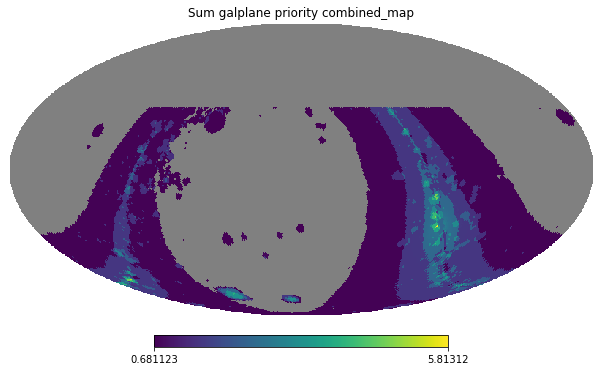

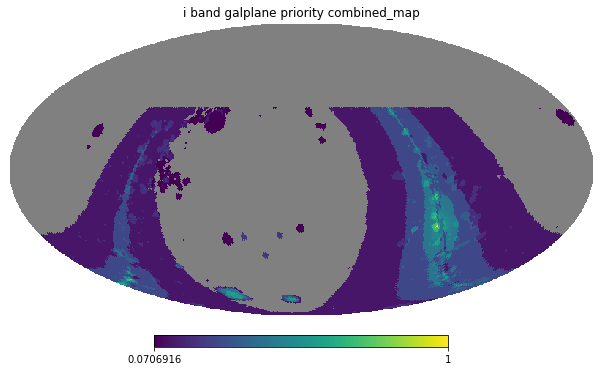

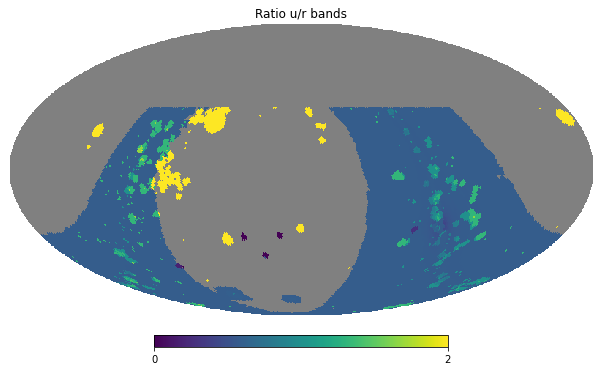

In [8]:
# Look at the total in all bandpasses
k = 'combined_map'
mapkey = maf.gp_priority_map_components_to_keys('sum', k)
good = np.where((slicePoints[mapkey] > 0.001) & (slicePoints['dec'] < np.radians(32)), 
              1, 0)
hp.mollview(np.where(good, slicePoints[mapkey], hp.UNSEEN), 
            title='Sum galplane priority combined_map',
           )

hp.mollview(np.where(good, 
                     slicePoints[maf.gp_priority_map_components_to_keys('i', k)], 
                     hp.UNSEEN), 
            title='i band galplane priority combined_map')

# estimate a typical filter ratio in these maps 
# (for some insight into why the results per filter might be different than that coming from the simulation,
#  where the simulation in v2.0 was created using a single pre-determined filter balance)
rkey = maf.gp_priority_map_components_to_keys('r', k)
fbalance = {}
for f in filterlist:
    if f == 'sum': 
        continue
    okey = maf.gp_priority_map_components_to_keys(f, k)
    tmp = slicePoints[okey][np.where(good==1)] / slicePoints[rkey][np.where(good==1)]
    print(f, np.median(tmp), np.mean(tmp))
    fbalance[f] = np.median(tmp)
    
okey = maf.gp_priority_map_components_to_keys('u', k)
rkey = maf.gp_priority_map_components_to_keys('r', k)
tmp = slicePoints[okey] / slicePoints[rkey]
hp.mollview(np.where(good, tmp, hp.UNSEEN), min=0, max=2, title= 'Ratio u/r bands')

print([f'{f}: {fbalance[f]:.2f}' for f in fbalance])

So the first problem is that these filter balance don't match the filter balances we were aiming for in the input to the scheduler -- the "goal" values there were 
`gal_plane_ratios = {"u": 0.18, "g": 1.0, "r": 1.05, "i": 1.05, "z": 1.0, "y": 0.23}` in the high-priority plane or bulge diamond, 
and `dusty_plane_ratios={"u": 0.1,"g": 0.28, "r": 0.28,"i": 0.28,"z": 0.28, "y": 0.1}` in the dusty plane.  These are scaled slightly differently (they include an overall weighting for the region compared to WFD r band), so let's rescale them so that the total = 1 in each, so we can see at a glance how this input ratio compares to the map goals. (and ignore the different total # of visits in each region).

In [9]:
gal_plane_ratios = {"u": 0.18, "g": 1.0, "r": 1.05, "i": 1.05, "z": 1.0, "y": 0.23}
dusty_plane_ratios={"u": 0.1,"g": 0.28, "r": 0.28,"i": 0.28,"z": 0.28, "y": 0.1}

scale = sum(gal_plane_ratios.values())
print("bulge/priority regions\t", [f'{f}: {gal_plane_ratios[f]/scale:.2f}' for f in gal_plane_ratios])
scale = sum(dusty_plane_ratios.values())
print("dusty plane\t\t", [f'{f}: {dusty_plane_ratios[f]/scale:.2f}' for f in dusty_plane_ratios])
scale = sum(fbalance.values())
print("median map goal ratio\t", [f'{f}: {fbalance[f]/scale:.2f}' for f in fbalance])

# for reference - low dust WFD region
low_dust_ratios={"u": 0.32, "g": 0.4, "r": 1.0, "i": 1.0, "z": 0.9, "y": 0.9}
scale = sum(low_dust_ratios.values())
print("low-dust WFD\t\t", [f'{f}: {low_dust_ratios[f]/scale:.2f}' for f in low_dust_ratios])

bulge/priority regions	 ['u: 0.04', 'g: 0.22', 'r: 0.23', 'i: 0.23', 'z: 0.22', 'y: 0.05']
dusty plane		 ['u: 0.08', 'g: 0.21', 'r: 0.21', 'i: 0.21', 'z: 0.21', 'y: 0.08']
median map goal ratio	 ['u: 0.11', 'g: 0.23', 'r: 0.18', 'i: 0.18', 'z: 0.19', 'y: 0.11']
low-dust WFD		 ['u: 0.07', 'g: 0.09', 'r: 0.22', 'i: 0.22', 'z: 0.20', 'y: 0.20']


The typical goal map ratios are more u and y band heavy, a little more g band, and a little less in riz than was asked for -- so we should expect to see (even in regions which were expected to be at the galactic plane filter balance) fewer than requested visits in u, g, and y band, and more visits than requested in r, i, and z.

#### Filter Balance Metrics ####

Let's look at the filter balance metrics, starting with the runs that deal with the footprint variations specifically. 
The baseline, vary nes, vary gp, and galactic plane footprint series are the primary families of runs that deal with the footprint specifically. There are some additional variations on footprint in the microsurvey set, but they are (intentionally) much more limited. 
This is a good place to start to look at the galactic plane metric variations. 

In [94]:
# So let's look at the filter balance metric results, 
# starting with the runs that deal with the footprint specifically.
fams = ['baseline', 'vary nes', 'vary gp', 'galactic plane footprint']
these_runs = families.explode('run').loc[fams]['run']

lines = maf.find_family_lines(families, fams)

msub = metric_sets.loc['GP filters']

summaries.loc[these_runs, msub['metric']]

metric,Mean GalplaneTimePerFilter_combined_map_u HealpixSlicer,Mean GalplaneTimePerFilter_combined_map_g HealpixSlicer,Mean GalplaneTimePerFilter_combined_map_r HealpixSlicer,Mean GalplaneTimePerFilter_combined_map_i HealpixSlicer,Mean GalplaneTimePerFilter_combined_map_z HealpixSlicer,Mean GalplaneTimePerFilter_combined_map_y HealpixSlicer,AreaThreshold GalplaneTimePerFilter_combined_map_u HealpixSlicer,AreaThreshold GalplaneTimePerFilter_combined_map_g HealpixSlicer,AreaThreshold GalplaneTimePerFilter_combined_map_r HealpixSlicer,AreaThreshold GalplaneTimePerFilter_combined_map_i HealpixSlicer,AreaThreshold GalplaneTimePerFilter_combined_map_z HealpixSlicer,AreaThreshold GalplaneTimePerFilter_combined_map_y HealpixSlicer
run,,,,,,,,,,,,
baseline_v2.1_10yrs,9.797666,0.567169,1.120588,1.118006,36.689500,27.459661,5198.584838,3578.748103,12237.740641,12366.991862,13151.731420,10635.529072
baseline_v2.0_10yrs,9.813913,0.603258,1.130789,1.065894,37.349263,27.715279,5412.604718,3962.305299,12795.031621,12395.527846,13322.947324,10928.442554
baseline_retrofoot_v2.0_10yrs,10.120957,0.477239,1.051199,1.029152,36.948332,28.836101,4937.564515,626.113059,10935.996197,10581.814279,12687.602035,11792.075715
retro_baseline_v2.0_10yrs,9.440329,0.486054,1.080328,1.041558,36.502290,28.981904,3791.928689,511.969124,11058.533069,10293.097265,12778.245748,11860.058500
vary_nes_nesfrac0.01_v2.0_10yrs,9.849866,0.601977,1.118689,1.070707,37.515890,27.758790,5088.637371,3948.876601,12741.316828,12375.384799,13238.178666,11053.497307
vary_nes_nesfrac0.05_v2.0_10yrs,9.600678,0.608260,1.116668,1.065908,36.535250,28.626359,5586.338503,3970.698235,12759.781288,12441.688997,13242.375134,11121.480093
vary_nes_nesfrac0.10_v2.0_10yrs,9.593961,0.619301,1.109908,1.061609,36.714984,27.862157,5211.174243,4331.594503,12769.013518,12419.028068,13319.590150,11039.229315
vary_nes_nesfrac0.15_v2.0_10yrs,9.771200,0.609960,1.107793,1.065914,36.141755,27.826420,5222.085061,4028.609497,12736.281066,12390.492084,13289.375578,11118.962212
vary_nes_nesfrac0.20_v2.0_10yrs,9.635180,0.612052,1.123998,1.054248,36.396305,27.994638,5420.997654,4161.217893,12778.245748,12550.797170,13326.304499,11068.604593


The 'Mean' summary values report the mean filter balance metric average over the map; the 'AreaThreshold' summary values report the amount of area in the galplane priority map that reached at least a value of 0.8. 

Thing that affect the filter balance values: 
* the galactic plane priority map overlaps the low-dust WFD, also the SCP and the NES. The filter balances in those regions influence the filter balance in the galactic plane evaluation, as well as the filter balance ratio set by the bulge diamond / dusty plane / galactic plane. 
* the SCP overlap skews the u band filter balance high
* the low-dust WFD region skews the y band ratio higher, even more so than the desired value
* the low-dust WFD region weights g band much lower than within the plane, skewing the g band balance lower
* This is in addition to the offset between the goal map filter ratios and the scheduler input filter ratio (which is really only ~10% effect or so).

The vary gp series does not modify the edges of the low-dust WFD footprint, but the filter ratio in the background dusty plane is different from the bulge diamond; as the vary gp fraction increases, the amount of time spent on the dusty plane also increases. <br>

The galactic plane footprint series does modify the edges of the low-dust WFD footprint; as additional areas of the galactic plane priority map come within the threshold values, these areas are assigned to the galactic plane rather than the low-dust WFD (and so inherit the galactic plane footprint filter balance, 'bulge diamond' above).

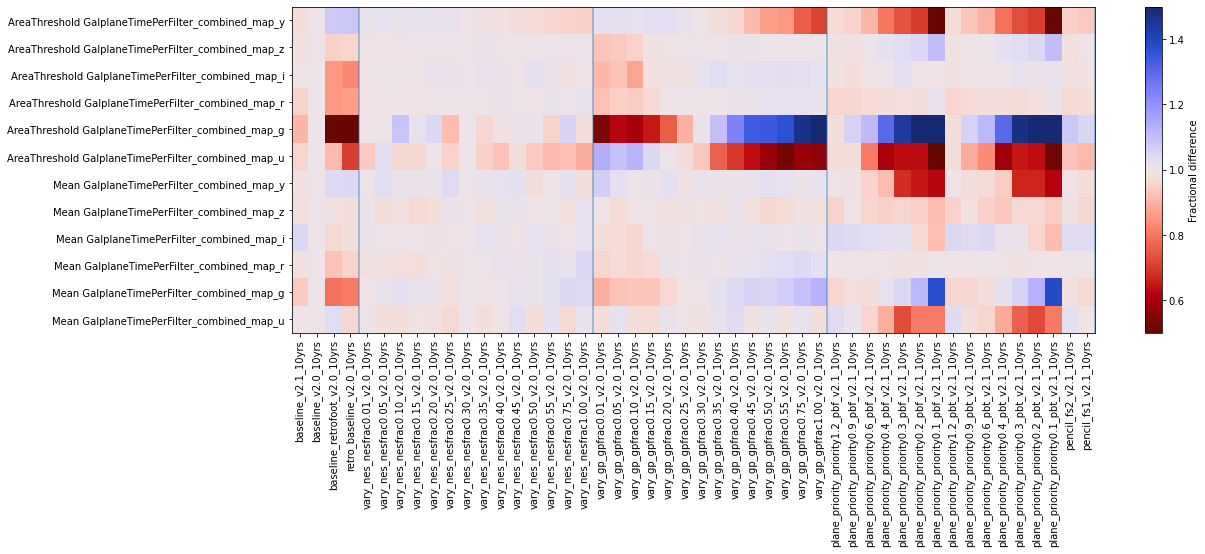

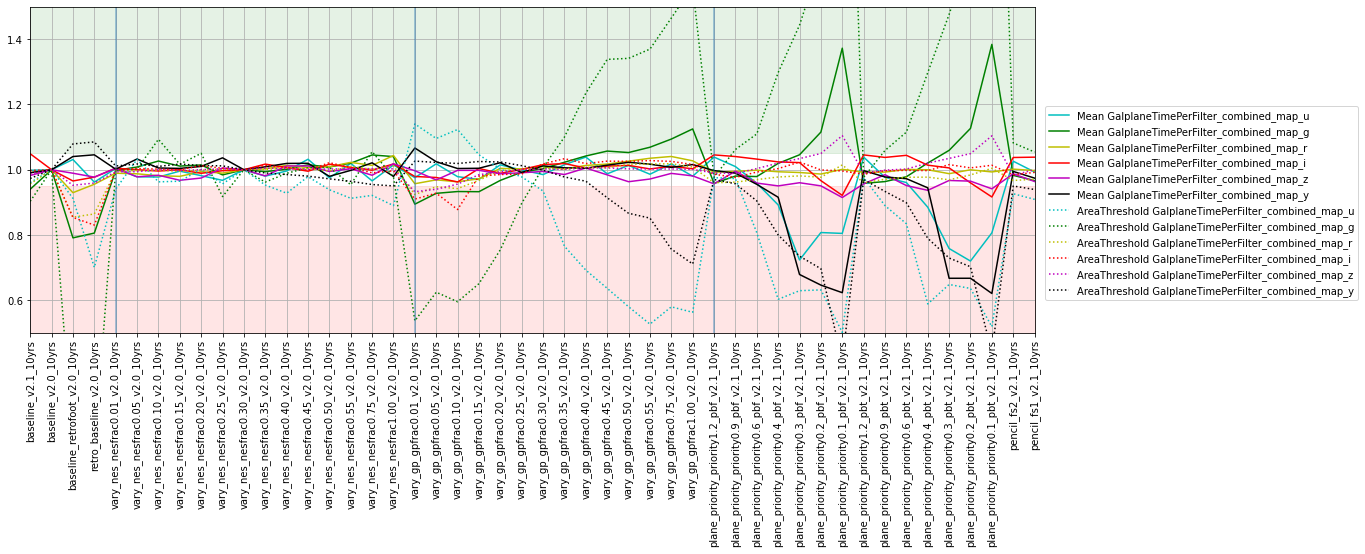

In [95]:
# Visualize the metric results
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']],
                                  baseline_run='baseline_v2.0_10yrs',
                                  metric_set=msub,
                                  metric_label_map=msub['short_name'])
fig.set_figheight(6)
fig.set_figwidth(18)
for l in lines:
    ax.axvline(l, alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']],
                             baseline_run='baseline_v2.0_10yrs',
                             metric_set=msub,
                             horizontal_quantity='run',
                             vertical_quantity='value',
                             metric_label_map=msub['short_name'])
plt.legend(loc=(1.01, 0.1))
fig.set_figwidth(18)
plt.ylim(0.5, 1.5)
for l in lines:
    ax.axvline(l, alpha=0.5)

Generally, it doesn't look like the vary_nes runs have a significant impact on the filter balance in the plane; this is in line with expectations. 

BUT looking at the vary gp and plane_priority runs, it gets much more complicated. 

Adding weight to the dusty plane region in the vary gp series means that the overall filter balance in the area skews from the bulge diamond values toward the dusty plane values; the major differences are in the area that meet the 0.8 threshold; the actual changes in the area involved are on the order of a few thousand (out of about two times that many) square degrees. As can be seen above, the dusty plane ratios put more time into u band than the bulge diamond ratios, but looking at the plots of the skymap results, it looks like as the priority of the dusty plane increased, it was added at the same filter ratio as the bulge diamond. This leads to the decrease in u and y band area, while the g band increases. 

In the plane_priority series, as the plane priority threshold decreases, more area is actually put into the plane filter balance region, rather than in the low-dust WFD/etc. The filter balances in the low-dust WFD are unintentionally "better" in some filters (like u and y band), so decreasing the threshold value (and increasing the visits in the plane region) leads to decreasing the area that meets the time requirements; however, the filter balance in the plane region is closer to the goal in g band, so the g band area increases. 

Conclusion: these generally seem to make sense, it would be useful to validate that these changing filter balances influence science metrics via populations in expected ways, and we can run simulations that match the goal filter balances more closely (but will result in fewer visits per pointing in r, i, and z bands than in the current simulations, in order to provide more u, g and y visits -- this may be complicated by weather and lunar cycle). 

*We will produce a few new simulations in v2.2 with the goal of more closely replicating the TVS goal filter values in the high priority regions, as well as better defining the high priority regions (so as not to vary the filter balance in the low-dust WFD).*

#### Footprint and visit interval metrics ####

The `Sum Galplane Footprint Tau XX` metrics reflect the total value of the priority map which is observed to at least YY visits, where the threshold value of YY is determined from the total number of visits required to adequately sample the footprint at timescale Tau XX (assuming the visits were distributed uniformly). With infinite visits, the value returned would be the sum of the priority map.

As we do not sample the sky uniformly, the `Sum GalPlane VisitTimescales Tau XX` metrics are also useful in determining if we have sampled the footprint with the general timescale desired. With infinite visits, the value returned would be the total number of pixels within the map (best metric value = 1 at each point). 

The Tau values and corresponding necessary number of visits per pointing (for the Footprint_Tau_XX) values are as follows: (tau is in units of days)

In [96]:
# What number of visits correspond to the threshold required for footprint_tau_XX
TAU_OBS = np.array([2.0, 5.0, 11.0, 20.0, 46.5, 73.0])
jj = [print(tau, int(maf.galplane_nvisits_thresholds(tau))) for tau in TAU_OBS]

2.0 1978
5.0 791
11.0 359
20.0 197
46.5 85
73.0 54


(0.2, 1.8)

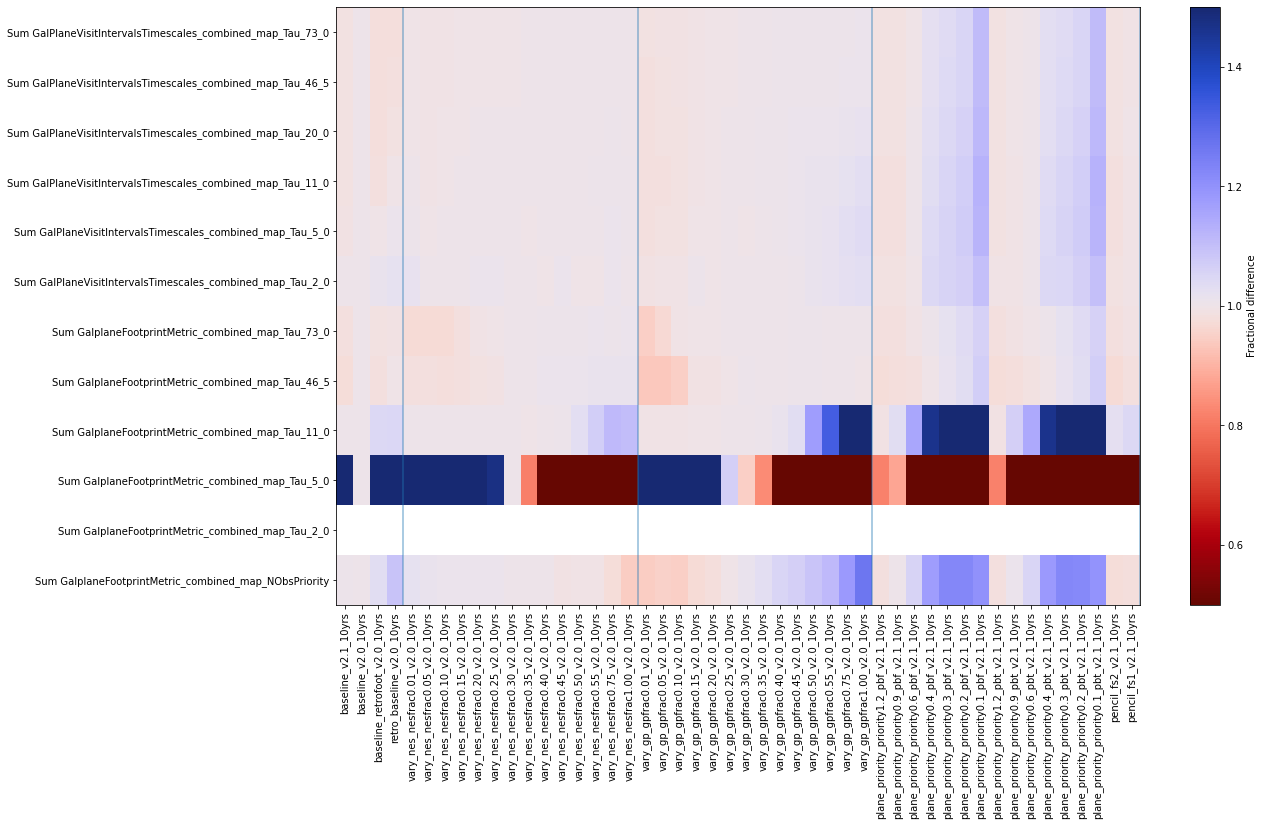

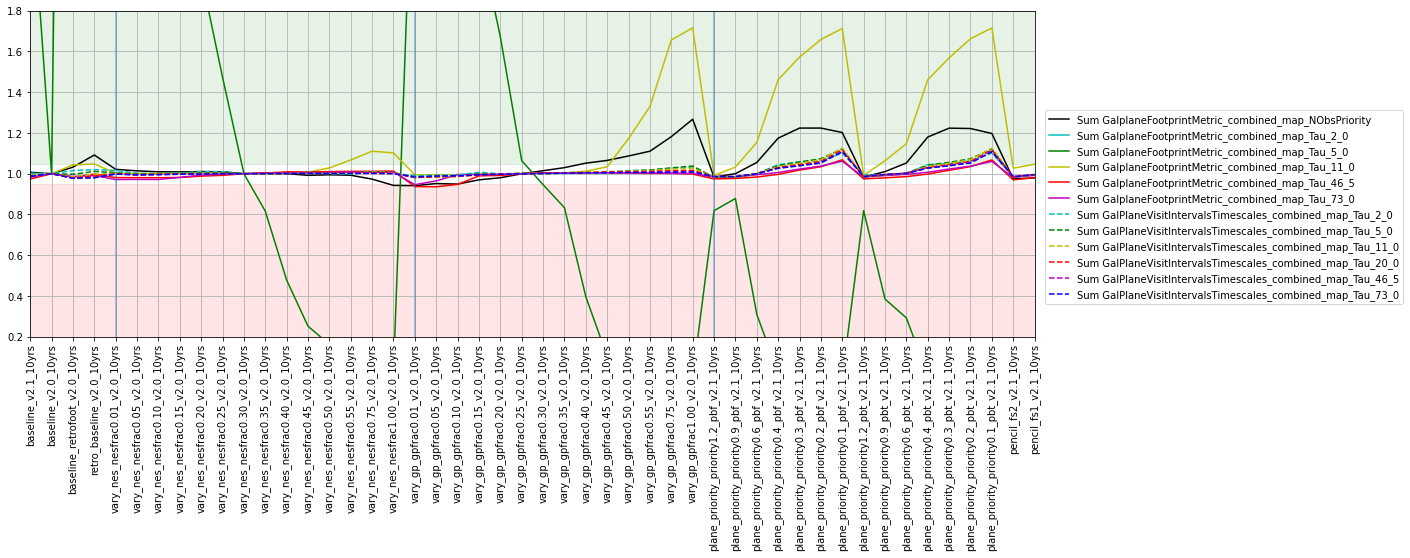

In [97]:
msub = metric_sets.loc[['GP footprint', 'GP visit']].reset_index('metric set')

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']],
                                  baseline_run='baseline_v2.0_10yrs',
                                  metric_set=msub,
                                  metric_label_map=msub['short_name'])
fig.set_figheight(11)
fig.set_figwidth(18)
for l in lines:
    ax.axvline(l, alpha=0.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']],
                             baseline_run='baseline_v2.0_10yrs',
                             metric_set=msub,
                             horizontal_quantity='run',
                             vertical_quantity='value',
                             metric_label_map=msub['short_name'])
plt.legend(loc=(1.01, 0.1))
fig.set_figwidth(18)
for l in lines:
    ax.axvline(l, alpha=0.5)
ax.set_ylim(.2, 1.8)

The first thing to note is the blank line at `Sum GalplaneFootprintMetric_combined_map_Tau_2_0` -- the reason this looks blank is because the value in the baseline is 0 (and thus the normalized values across the board become infinite. Looking more closely at the actual value of this summary stat over all runs:

In [98]:
k = 'Sum GalplaneFootprintMetric_combined_map_Tau_2_0  HealpixSlicer'
nonzero = np.where(summaries[k] > 0)
summaries.iloc[nonzero][k]

run
carina_v2.0_10yrs                      22.358353
ddf_euclid_moved_slf0.20_v2.1_10yrs    12.666731
smc_movie_v2.0_10yrs                   30.003297
Name: Sum GalplaneFootprintMetric_combined_map_Tau_2_0  HealpixSlicer, dtype: float64

Two of these are microsurveys which intentionally get many more visits in the region within the combined_map; the last is a test run to see the effect of moving the 5th DDF and I moved it to a point slightly within the combined_map footprint by accident. Without a microsurvey increasing the number of visits per pointing to well beyond 1978 visits (remember, typical WFD points receive ~850 visits), this summary metric can be expected return poor results. 

Let's look at the other metrics, as these are all displaying what look like useful trends across the different  footprint families of simulations.

First, it's worth noting that the timesampling values reported by the VisitIntervalsMetric vary in a relatively straightforward way: as more time is added into the galactic plane regions, the time sampling improves. 
Adding more time into the NES doesn't improve the time sampling within the galactic plane map region. Adding time by just generally adding more visits into the dusty plane (vary gp frac) increases the time sampling slowly (remember the sum metric value is the total across all galactic plane pixels, and as time goes into the dusty plane, it goes out of the 'wings' of the plane map which was previously the low-dust WFD, and also it's added evenly across that entire area).  Adding time by specifically increasing the part of the dusty plane region to WFD-levels while leaving the remainder at dusty plane levels (by changing the threshold for the priority map) increases the time sampling more rapidly, as some parts of the sky become "very good" more quickly. A small footprint difference accounts for the slight difference in final VisitIntervalsMetric results when they are 'saturated' with the most visits in the plane.

Second, the footprint metric values vary in a slightly more complex way. In this metric, the absolute number of visits are the threshold, so if more visits are available (such as due to taking visits out of the NES) or fewer visits are available (such as adding visits to the NES), the changing area which reaches the required sampling thresholds will show up in the Sum FootprintMetric. This shows up at different timescales (Tau) values, as the drop occurs.

The same thing happens as the time spent in the dusty plane or at lower fractions of the plane priority map increases, as then the highest priority parts of the priority map start to fall below 791 visits per pointing (the TAU=5 threshold).  However -- at Tau=11, the threshold number of visits per pointing is only 359, and so more area reaches this threshold (the baseline dusty plane value is ~250 visits per pointing), so adding more time into the dusty plane or lower threshold values of the plane priority map, increases the area which reaches this more modest threshold. 

#### Comment ####
This demonstrates a tension even within the combined priority map, based on where visits are concentrated and what timescales are necessarily better sampled. With a limited number of visits available, there will need to be a choice whether to concentrate them in space towards the highest priority regions, enabling those regions to better sample shorter timescales (tau=5), or more evenly over the plane priority region, allowing better sampling over more of the sky at longer timescales (tau>=11). Given the wide range of timescales above Tau=11, if these events are more common, it may make sense to aim for wider but slightly less dense coverage (and we can see if it's possible to make this up with different rolling cadence options or future cadence modifications). 

We can check for different results across the different science maps for the particular timescales of the Footprint metric that look like they vary:

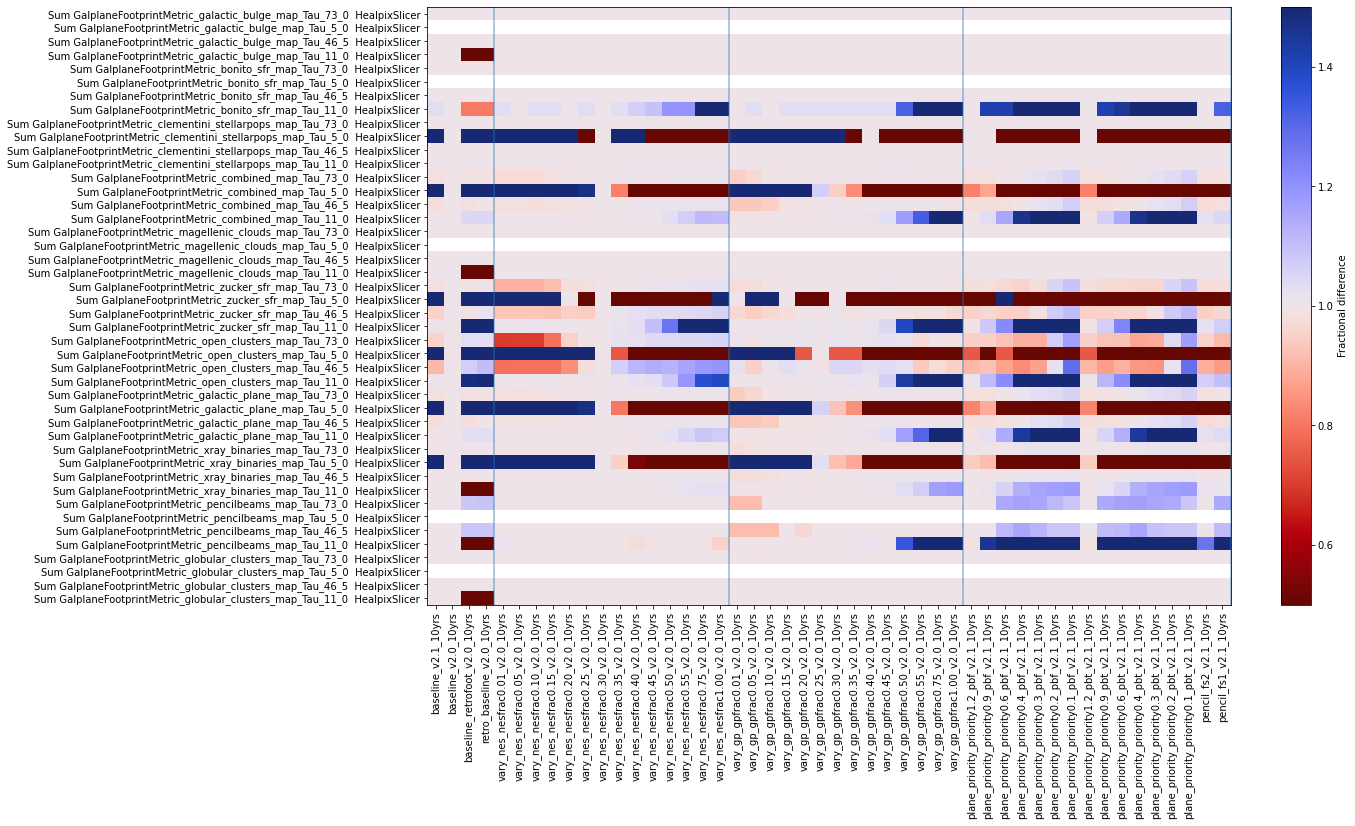

In [105]:
metrics = [m for m in summaries if 'FootprintMetric' in m and  'Sum' in m and 
           ('Tau_5_0' in m or 'Tau_11_0' in m or 'Tau_46_5' in m or 'Tau_73_0' in m)]  
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics],
                                  baseline_run='baseline_v2.0_10yrs',
                                  color_range=1) 
fig.set_figheight(11)
fig.set_figwidth(18)
for l in lines:
    ax.axvline(l, alpha=0.5)

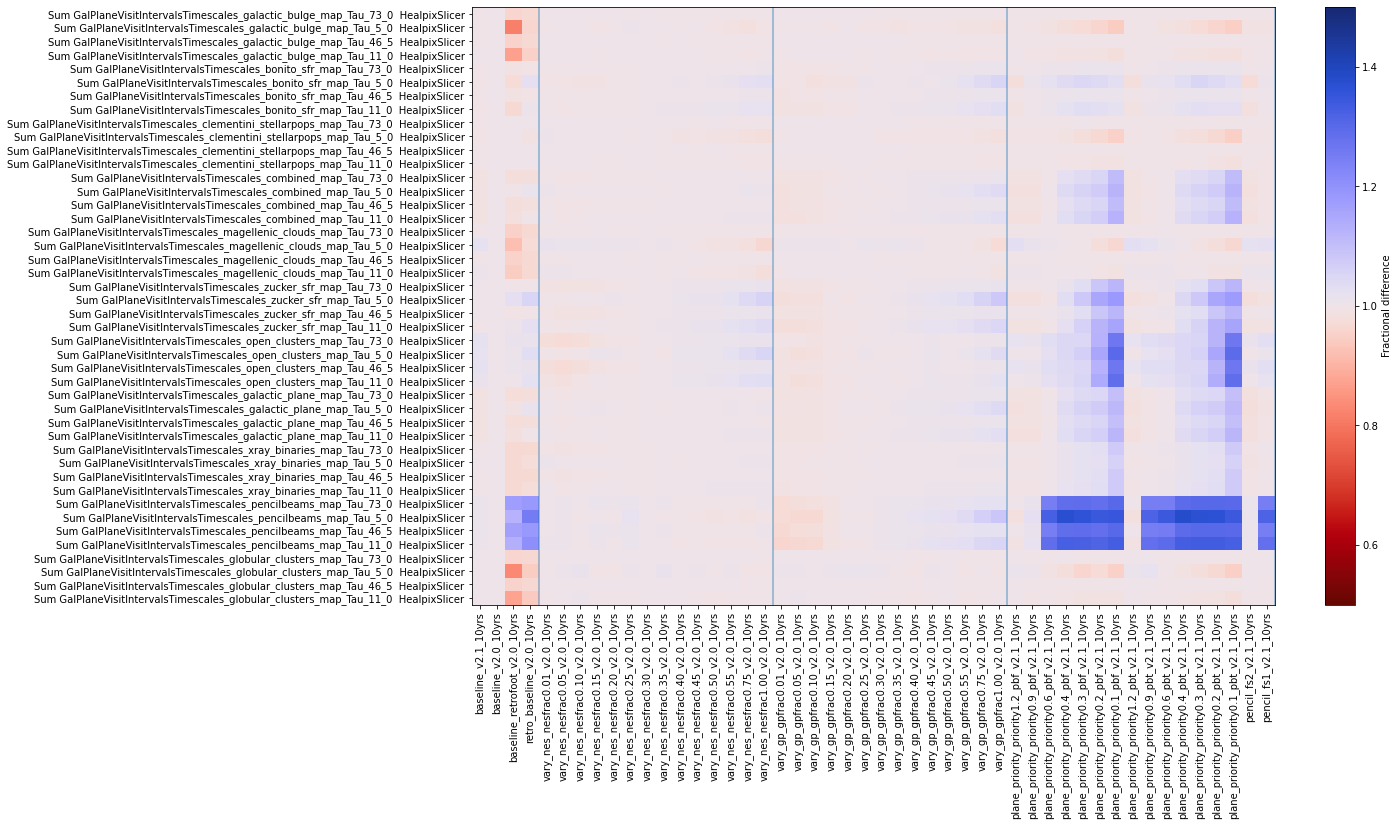

In [106]:
metrics = [m for m in summaries if 'VisitIntervals' in m and  'Sum' in m and 
           ('Tau_5_0' in m or 'Tau_11_0' in m or 'Tau_46_5' in m or 'Tau_73_0' in m)]
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics],
                                  baseline_run='baseline_v2.0_10yrs',
                                  color_range=1)
fig.set_figheight(11)
fig.set_figwidth(18)
for l in lines:
    ax.axvline(l, alpha=0.5)

If Tau=5 is excluded from the footprint metrics, then generally "more time in the plane leads to better metrics" for all maps. And more time in the plane leads to better visit interval sampling, for almost all maps. 
This does show again the tension between more visits over more area vs. fewer visits over smaller area. 


#### SeasonGapInterval metrics ####

These metrics are primarily aimed at detecting if there was an unusual seasonal gap. In practice, they highlight simulations which extend the season length. The value reported is similar to the `Sum VisitIntervalsMetric Tau_XXX`, in that the time gaps between seasons are evaluated and compared to the Tau value (which here, is 5 times longer than the Tau values for the variability); if the season gap is shorter than the expected value (145 days) the metric value per pixel is 1, otherwise it decays toward 0 with a timescale of Tau. Visits distributed over very long seasons would give values of 1 * number of pixels in the metric slicer, shorter seasons (longer gaps) will give increasing values as Tau increases.

In [107]:
summaries.loc[these_runs, metric_sets.loc['GP season']['metric']]

metric,Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_10_0 HealpixSlicer,Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_25_0 HealpixSlicer,Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_55_0 HealpixSlicer,Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_100_0 HealpixSlicer,Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_232_5 HealpixSlicer,Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_365_0 HealpixSlicer
run,,,,,,
baseline_v2.1_10yrs,1519.281717,1537.342617,2418.710547,6044.632082,14874.361971,15807.386897
baseline_v2.0_10yrs,1709.867962,1728.897848,2639.113746,6342.459297,15214.070295,16033.511216
baseline_retrofoot_v2.0_10yrs,1315.156602,1333.274476,2238.862759,5929.269931,14722.353618,15691.129516
retro_baseline_v2.0_10yrs,201.990083,224.034031,1285.037666,5411.452888,14604.724726,15694.002456
vary_nes_nesfrac0.01_v2.0_10yrs,1858.548514,1877.224622,2756.834762,6313.277327,14877.162424,15903.774617
vary_nes_nesfrac0.05_v2.0_10yrs,1937.752109,1956.716381,2841.600154,6384.524224,14792.913990,15779.878822
vary_nes_nesfrac0.10_v2.0_10yrs,1779.759582,1798.195600,2674.584570,6242.208903,14905.904688,15975.667774
vary_nes_nesfrac0.15_v2.0_10yrs,1901.867927,1920.098432,2789.233673,6340.869920,14991.283292,16023.395697
vary_nes_nesfrac0.20_v2.0_10yrs,1765.634617,1784.316243,2670.071143,6280.980194,15032.618263,16018.677088


In [108]:
# Variation in the metric values when *not* considering the retro baseline version (without rolling cadence)
tt = families.explode('run').loc[['vary nes', 'vary gp', 'galactic plane footprint']]['run']
tt = np.concatenate([['baseline_v2.0_10yrs'], tt])
summaries.loc[tt, metric_sets.loc['GP season']['metric']].max()\
      - summaries.loc[tt, metric_sets.loc['GP season']['metric']].min(),\
summaries.loc[tt, metric_sets.loc['GP season']['metric']].mean()

(metric
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_10_0  HealpixSlicer      732.892466
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_25_0  HealpixSlicer      732.792180
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_55_0  HealpixSlicer     1001.976537
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_100_0  HealpixSlicer    2263.346214
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_232_5  HealpixSlicer    3036.710525
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_365_0  HealpixSlicer    1819.011819
 dtype: float64,
 metric
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_10_0  HealpixSlicer      1618.914637
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_25_0  HealpixSlicer      1640.306222
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_55_0  HealpixSlicer      2638.743390
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_100_0  HealpixSlicer     6547.766659
 Sum GalPlaneSeasonGapsTimescales_combined_map_Tau_232_5  HealpixSlicer    15370.290540
 Sum 

In [109]:
# Nside that the metric was run at is relevant (because this is a simple 'sum' over all of the metric values)
nside = 64
print(f'The variance of 732 above corresponds to ~732 pixels falling from 1 to 0, '
      f'or about {hp.nside2pixarea(nside, degrees=True) * 732} sq degrees, as the season length falls below 145 days')

The variance of 732 above corresponds to ~732 pixels falling from 1 to 0, or about 614.362948294574 sq degrees, as the season length falls below 145 days


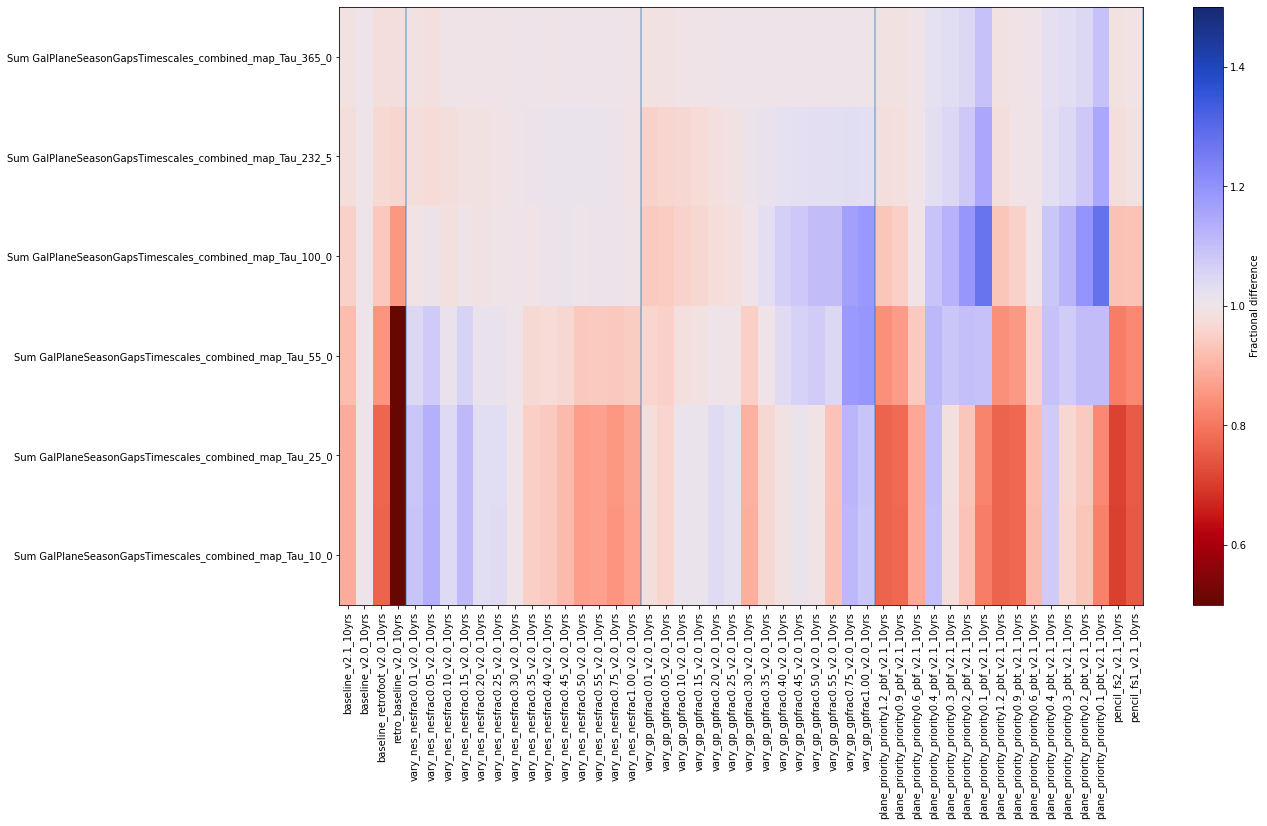

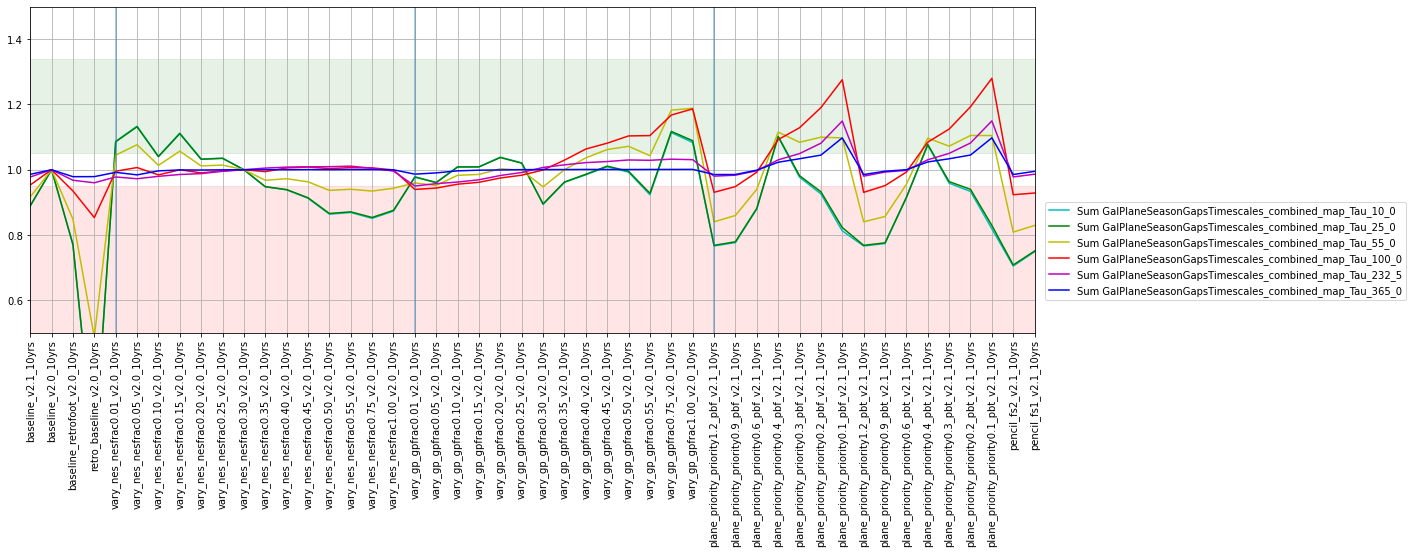

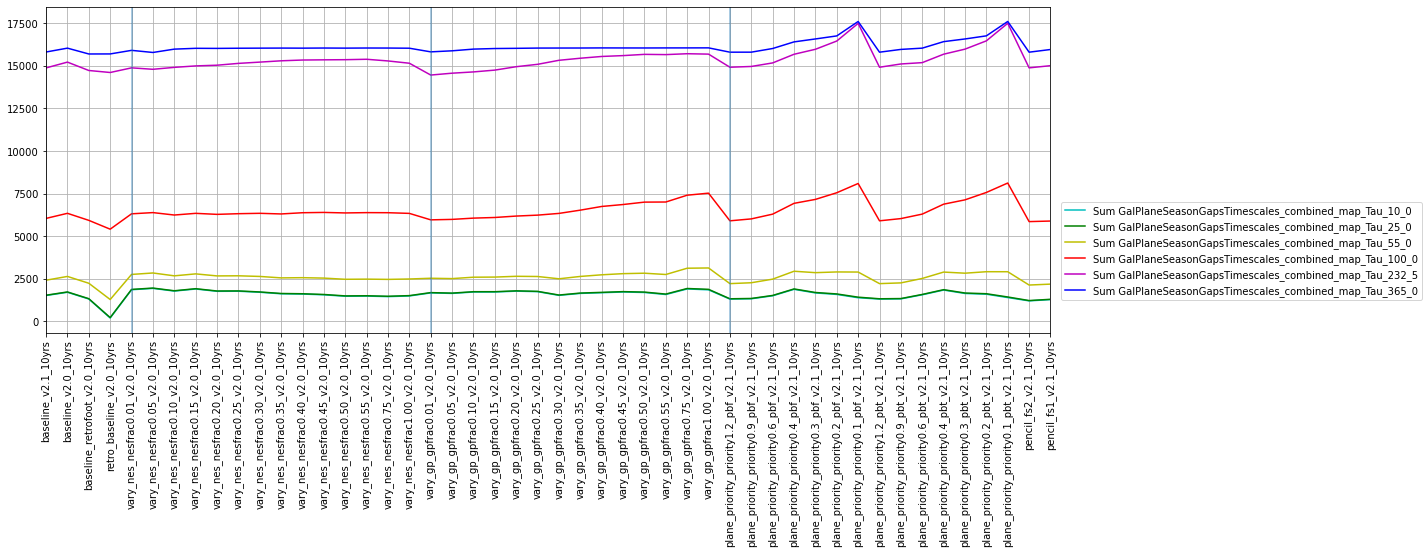

In [110]:
msub = metric_sets.loc['GP season']

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']],
                                  baseline_run='baseline_v2.0_10yrs',
                                  metric_set=msub,
                                  metric_label_map=msub['short_name'])
fig.set_figheight(11)
fig.set_figwidth(18)
for l in lines:
    ax.axvline(l, alpha=0.5)
    
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']],
                             baseline_run='baseline_v2.0_10yrs',
                             metric_set=msub,
                             horizontal_quantity='run',
                             vertical_quantity='value',
                             metric_label_map=msub['short_name'])
plt.legend(loc=(1.01, 0.1))
fig.set_figwidth(18)
for l in lines:
    ax.axvline(l, alpha=0.5)
ax.set_ylim(0.5, 1.5)

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']],
                             #baseline_run='baseline_v2.0_10yrs',
                              shade_fraction=0,
                             metric_set=msub,
                             horizontal_quantity='run',
                             vertical_quantity='value',
                             metric_label_map=msub['short_name'])
plt.legend(loc=(1.01, 0.1))
fig.set_figwidth(18)
for l in lines:
    ax.axvline(l, alpha=0.5)
#ax.set_ylim(0.5, 1.5)

The last plot above is not normalized, as it seemed simpler to understand this way. As the timescale increases, more of parts of the sky and more season gaps are "good" (larger metric values). At the longest Tau values (tau=365, 232), the season gap is basically only 'bad' if part of the sky is not observed in a given year (this could happen with a skipped season or around the edges of the footprint due to dithering). At the shortest tau values (Tau=10/25), if the season gap is less than the expected season it is counted as "good" and otherwise, the metric value falls very quickly to 0 for that pixel; this becomes a measure of how often the season was 'longer than 220 days'. At tau=100, there is a mix between longer than typical seasons (gaps of 145 days/ season lengths of 220 days) and how long the gap was compared to tau. Typically, the season length is longer in the parts of the sky with WFD-level visits, so as more area is covered with more visits, the `Sum SeasonGapsInterval_Tau_XX` value increases. 

The reason for plotting the not normalized values is to show that the actual values change very little as the NES fraction is varied,  although in the normalized version just above, the normalized sum of the season gaps value at short Tau varies significantly; I believe this is because small changes in the season length result in large changes of the metric value due to the fast decay with small Tau. On the other hand, small changes in the season length above/below the gap=145 day value have a more moderate effect on the metric value at Tau=100. 

This does show some slight tension as more visits are added into the dusty plane, although more visits are generally better for all timescales, the metric results get slightly worse for very short Tau values; this seems likely to be because some area that was getting longer than 220 day seasons now is not. 

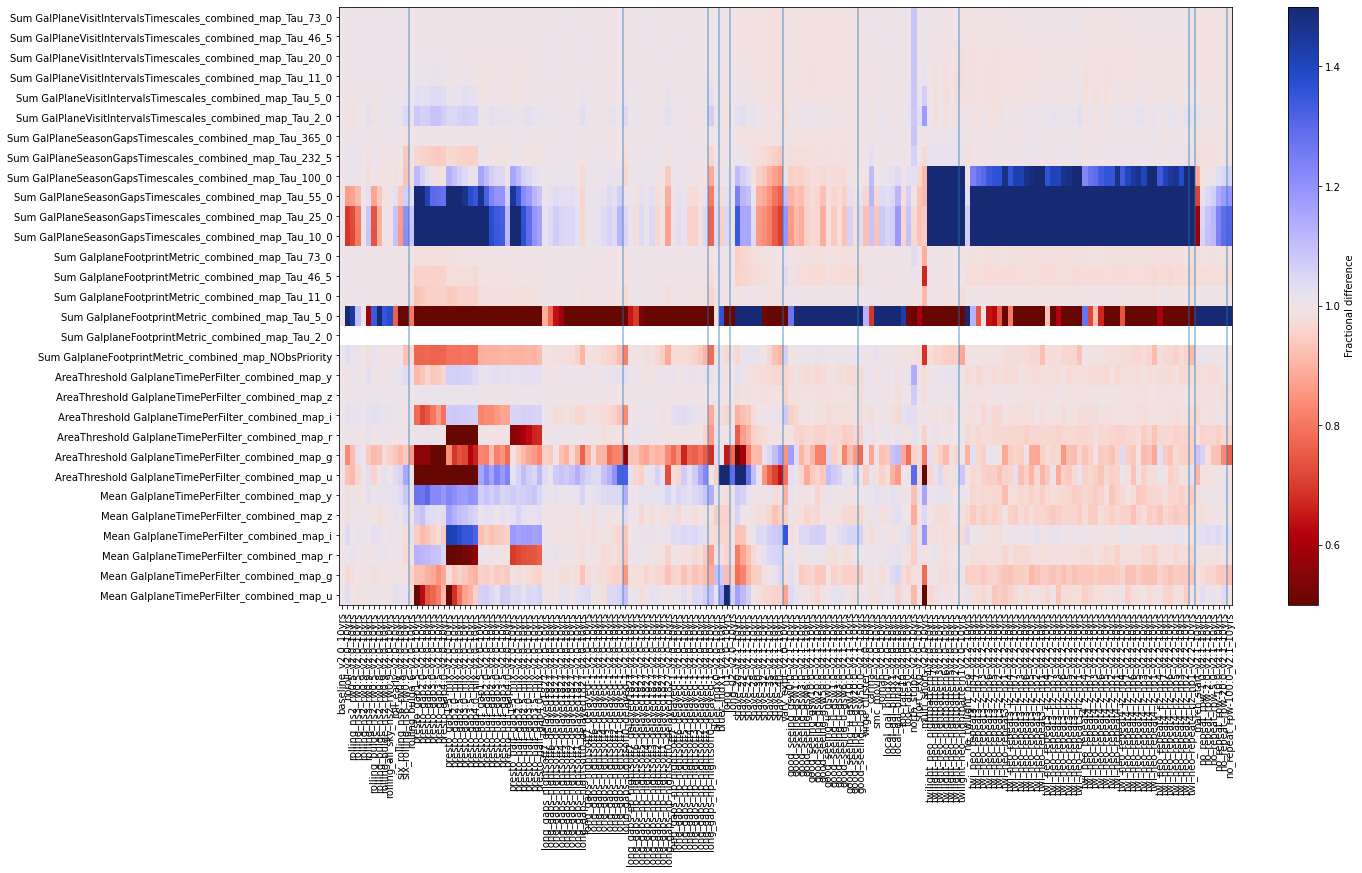

In [111]:
# Let's peek at metric results for everything else now

fams = [f for f in families.index if not f.startswith('ddf') and 
       (f!='baseline' and f!='vary nes' and f!='vary gp' and f!='galactic plane footprint')]
these_runs = np.concatenate([['baseline_v2.0_10yrs'], families.explode('run').loc[fams]['run']])

lines = maf.find_family_lines(families, fams)

msub = metric_sets.loc[gp].reset_index('metric set')

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']],
                                  baseline_run='baseline_v2.0_10yrs',
                                  metric_set=msub,
                                  metric_label_map=msub['short_name'])
fig.set_figheight(11)
fig.set_figwidth(20)
for l in lines:
    ax.axvline(l, alpha=0.5)


This highlights some families where the metric results vary strongly. The twilight NEO series, in particular shows some strong variation in the seasonGaps -- these runs add high airmass, low-solarelongation visits which extend the season length where the microsurvey operates. Because the microsurvey also requires additional visits, it pulls down the FootprintMetric at Tau=5 as part of the galactic plane region fall below the 791 threshold number of visits per pointing. There are similar effects for some other microsurveys, which can be especially beneficial if the microsurvey is within the galactic plane footprint.

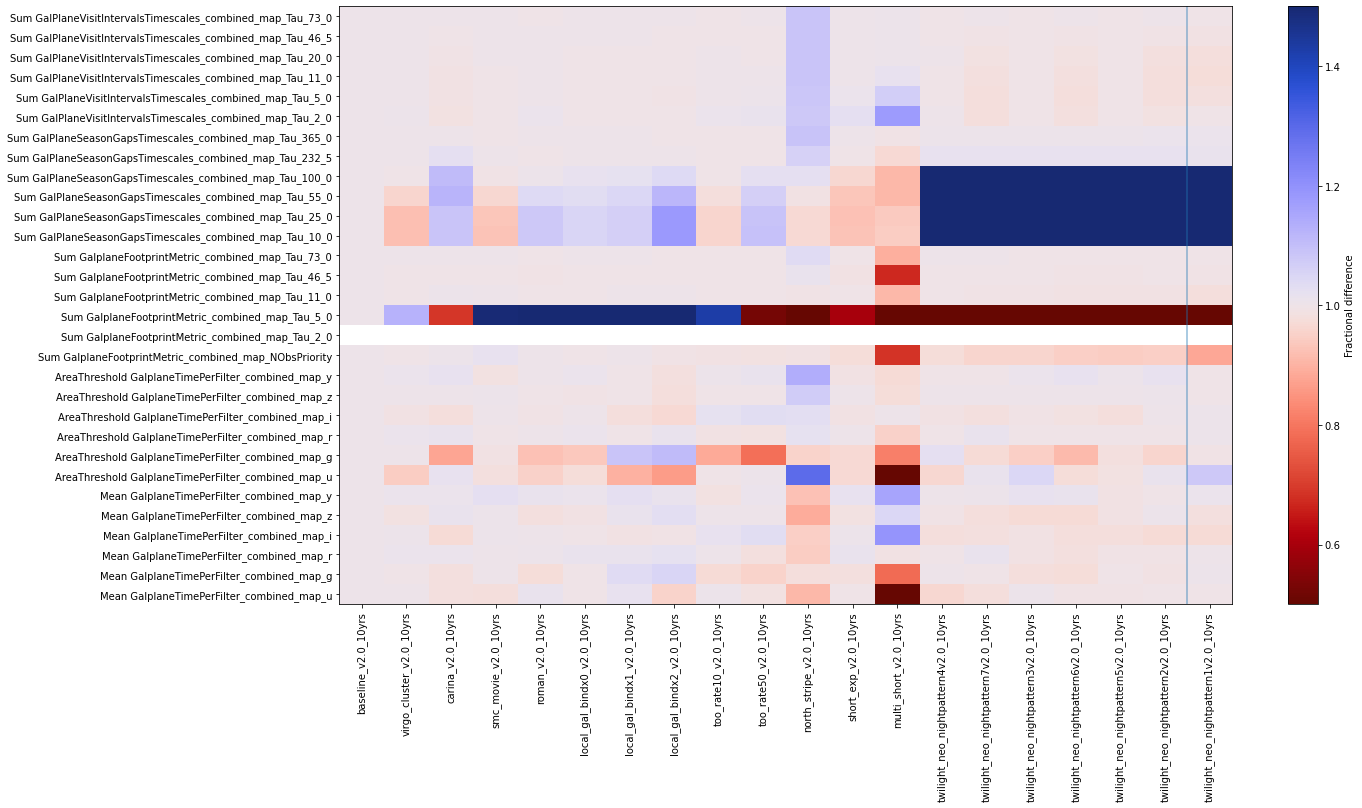

In [112]:
fams = ['microsurveys']
these_runs = np.concatenate([['baseline_v2.0_10yrs'], families.explode('run').loc[fams]['run']])

lines = maf.find_family_lines(families, fams)

msub = metric_sets.loc[gp].reset_index('metric set')

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']],
                                  baseline_run='baseline_v2.0_10yrs',
                                  metric_set=msub,
                                  metric_label_map=msub['short_name'])
fig.set_figheight(11)
fig.set_figwidth(20)
for l in lines:
    ax.axvline(l, alpha=0.5)

Another series that showed impacts was the triplets family. 
This seems likely to be because the season length is again extended when triplets are observed (although we're not entirely clear on why), and is most strong in the presto / presto_half series where triplets occur more often through the night. In these runs, the total number of visits falls (the typical slews are longer) so the Footprint at Tau=5 again falls, due to parts of the sky falling below 791 visits per pointing. 
It's not obvious why the filter balance changes, but likely it's due to which filters are being chosen for the pairs (presto_mix uses different pairs of filters than presto, etc.) and this having an impact on the overall filter ratio at all points in the sky. 
Beyond the season gaps and disturbance to the filter balance, the series is generally neutral. 

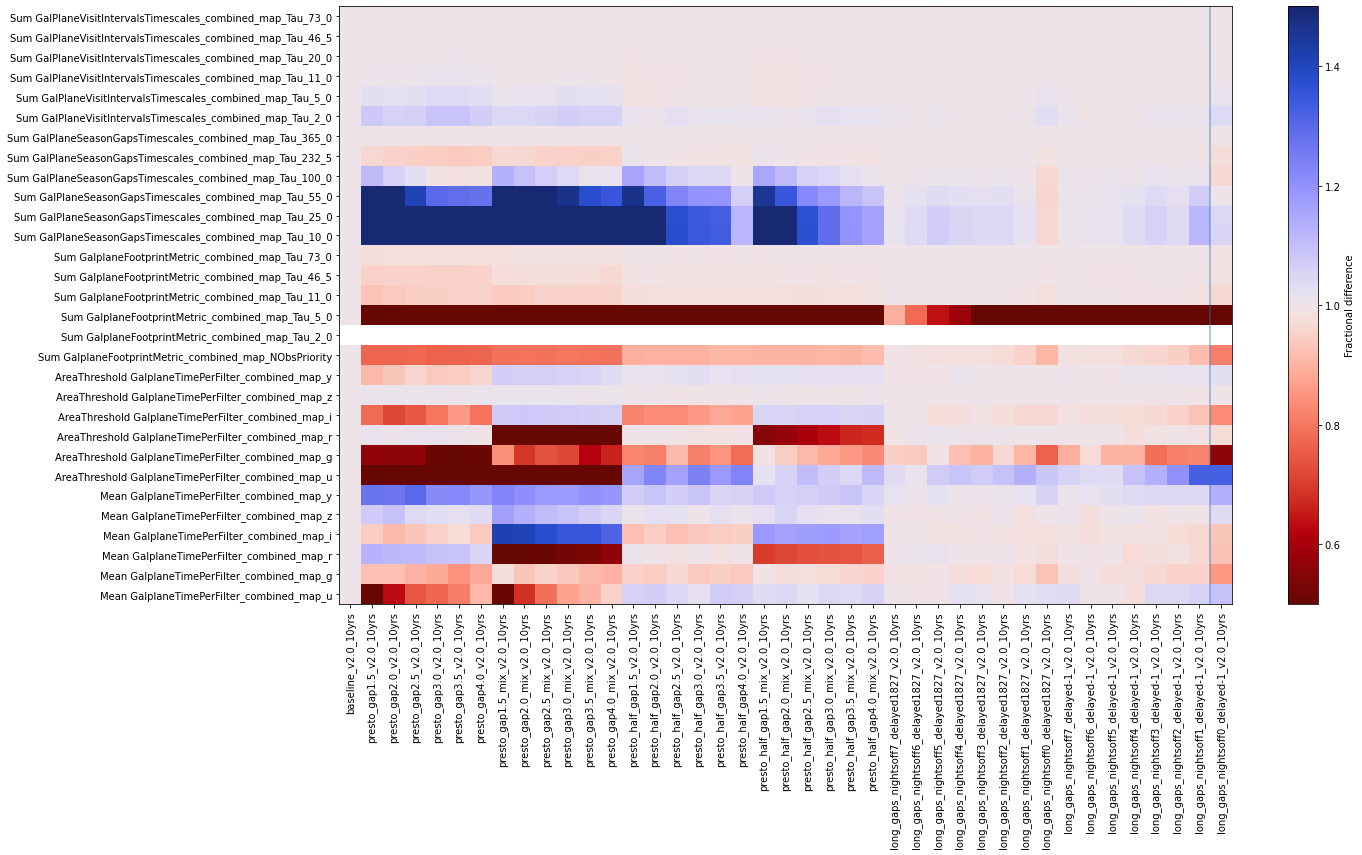

In [113]:
fams = ['triplets']
these_runs = np.concatenate([['baseline_v2.0_10yrs'], families.explode('run').loc[fams]['run']])

lines = maf.find_family_lines(families, fams)

msub = metric_sets.loc[gp].reset_index('metric set')

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']],
                                  baseline_run='baseline_v2.0_10yrs',
                                  metric_set=msub,
                                  metric_label_map=msub['short_name'])
fig.set_figheight(11)
fig.set_figwidth(20)
for l in lines:
    ax.axvline(l, alpha=0.5)

The rolling cadence family demonstrates a trade-off between the season gaps at Tau=10/25 and the footprint tau=5 metric. These particular tau values and metrics correspond to places where thresholds are easily crossed; parts of the sky are likely popping above and below 791 visits per pointing, and above and below the 220 day season length / 145 day season gap threshold; also, a relatively small amount of WFD-level sky is involved within the galactic plane. I suspect most of these variations are due to noise, rather than meaningful variations in the survey strategy. 

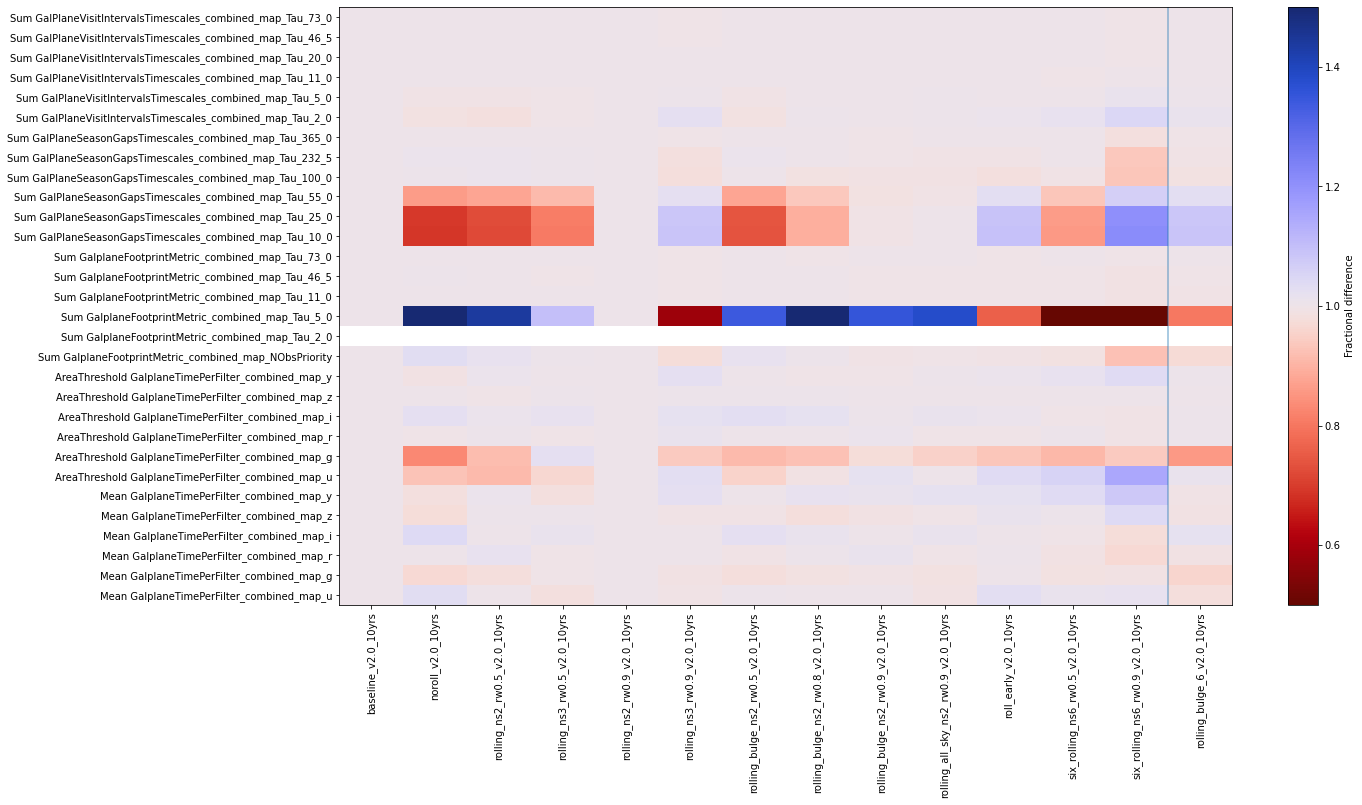

In [114]:
fams = ['rolling']
these_runs = np.concatenate([['baseline_v2.0_10yrs'], families.explode('run').loc[fams]['run']])

lines = maf.find_family_lines(families, fams)

msub = metric_sets.loc[gp].reset_index('metric set')

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']],
                                  baseline_run='baseline_v2.0_10yrs',
                                  metric_set=msub,
                                  metric_label_map=msub['short_name'])
fig.set_figheight(11)
fig.set_figwidth(20)
for l in lines:
    ax.axvline(l, alpha=0.5)

Checking in on the 'not-so-volatile' metrics for the families we haven't more closely explored above, we see little variation. 

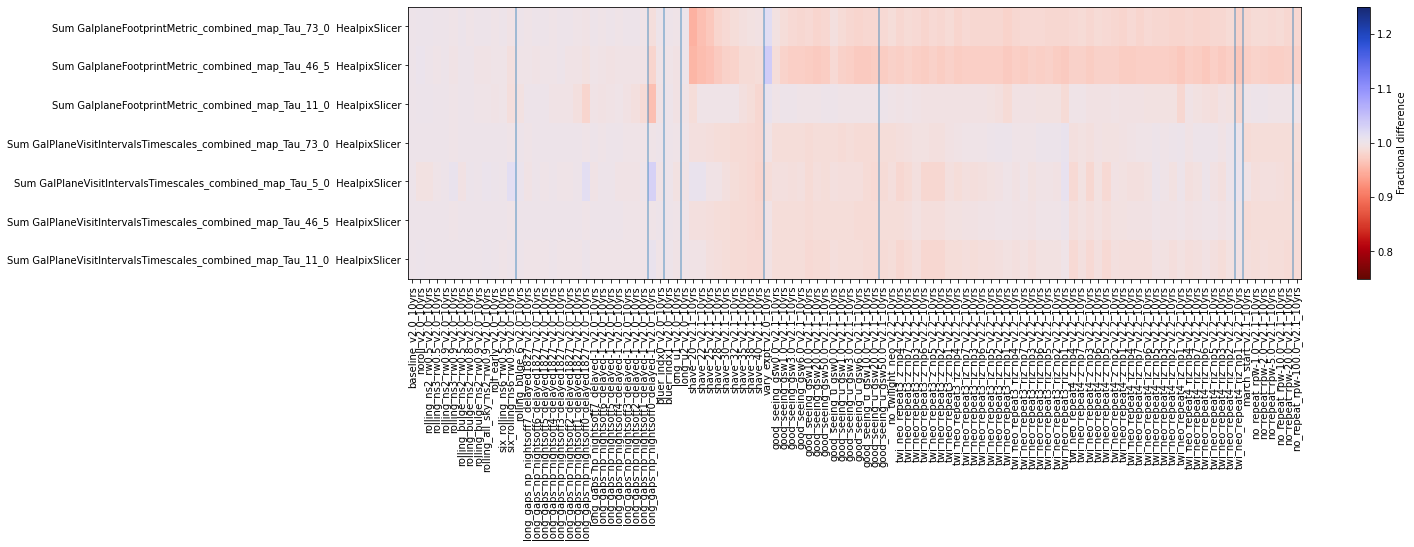

In [127]:
# Let's make a subset of metric values maybe and then a final plot that might be easier to read
fams = [f for f in families.index if not f.startswith('ddf') and 
       (f!='baseline' and f!='vary nes' and f!='vary gp' and f!='galactic plane footprint') and
       (f!='microsurveys') and (f!='triplets')]
these_runs = np.concatenate([['baseline_v2.0_10yrs'], families.explode('run').loc[fams]['run']])

lines = maf.find_family_lines(families, fams)

metrics = [m for m in summaries if 'SeasonGapsMetric' in m and 'Sum' in m and 'combined_map' in m and 
          ('Tau_55_0' in m or 'Tau_100_0' in m)]
metrics += [m for m in summaries if 'VisitIntervals' in m and 'Sum' in m and 'combined_map' in m and 
           ('Tau_5_0' in m or 'Tau_11_0' in m or 'Tau_46_5' in m or 'Tau_73_0' in m)]
metrics += [m for m in summaries if 'FootprintMetric' in m and  'Sum' in m and 'combined_map' in m and
           ('Tau_11_0' in m or 'Tau_46_5' in m or 'Tau_73_0' in m)]  
metrics += [m for m in summaries if 'FilterTime' in m and  'Area' in m and 'combined_map' in m]



fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics],
                                  baseline_run='baseline_v2.0_10yrs',
                                  color_range=0.5) # note smaller dynamic range
fig.set_figheight(5)
fig.set_figwidth(20)
for l in lines:
    ax.axvline(l, alpha=0.5)

(0.0, 2.5)

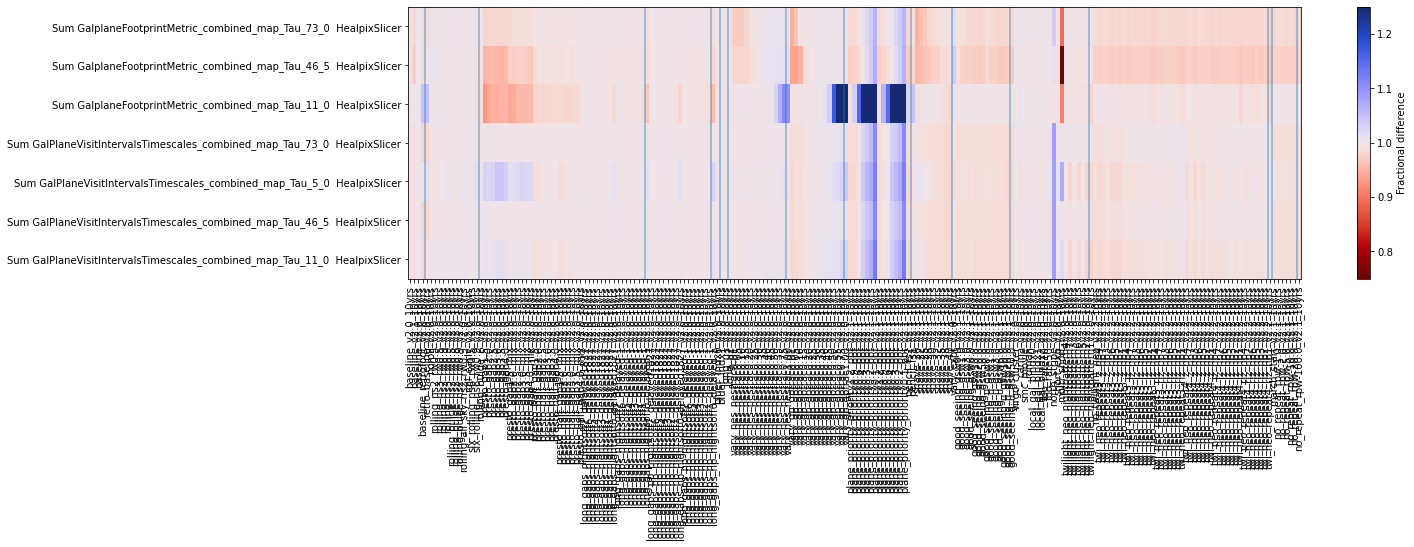

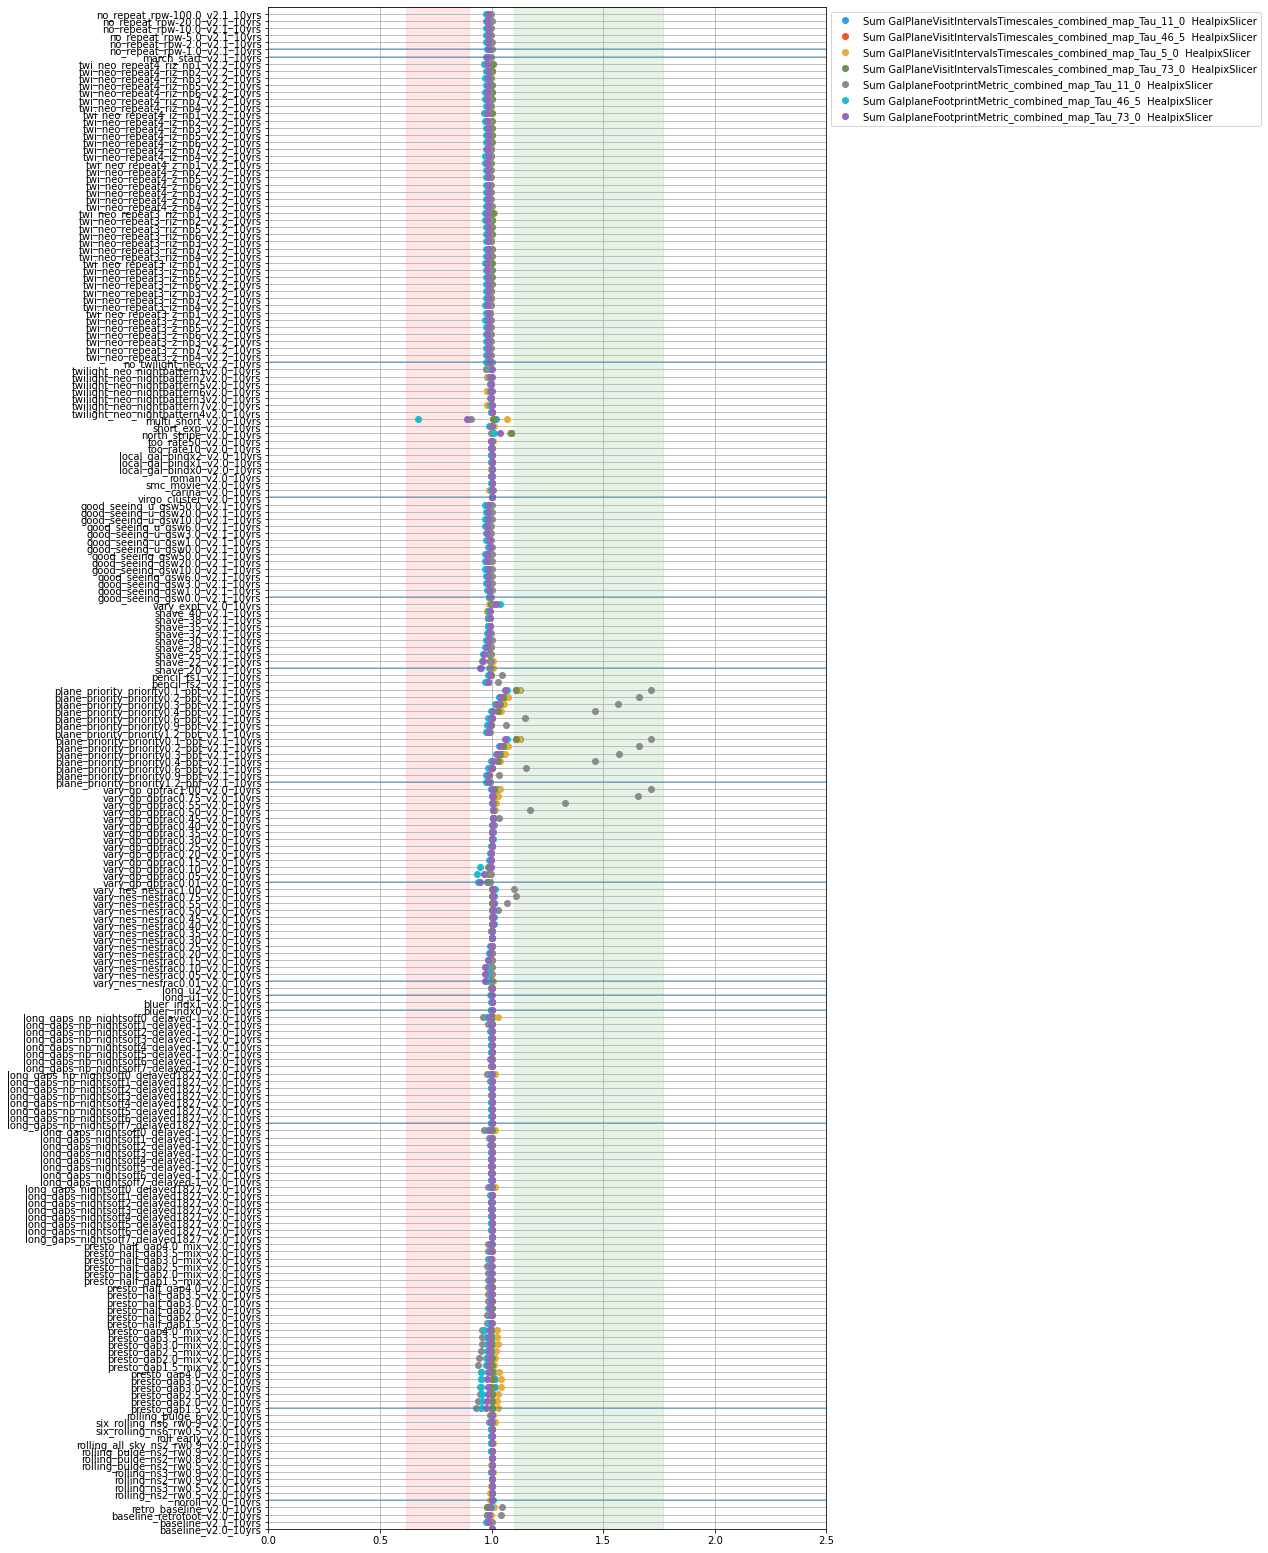

In [136]:
# Let's make a subset of metric values maybe and then a final plot that might be easier to read
fams = [f for f in families.index if not f.startswith('ddf')]
these_runs = np.concatenate([['baseline_v2.0_10yrs'], families.explode('run').loc[fams]['run']])

lines = maf.find_family_lines(families, fams)

metrics = [m for m in summaries if 'SeasonGapsMetric' in m and 'Sum' in m and 'combined_map' in m and 
          ('Tau_55_0' in m or 'Tau_100_0' in m)]
metrics += [m for m in summaries if 'VisitIntervals' in m and 'Sum' in m and 'combined_map' in m and 
           ('Tau_5_0' in m or 'Tau_11_0' in m or 'Tau_46_5' in m or 'Tau_73_0' in m)]
metrics += [m for m in summaries if 'FootprintMetric' in m and  'Sum' in m and 'combined_map' in m and
           ('Tau_11_0' in m or 'Tau_46_5' in m or 'Tau_73_0' in m)]  
metrics += [m for m in summaries if 'FilterTime' in m and  'Area' in m and 'combined_map' in m]



fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics],
                                  baseline_run='baseline_v2.0_10yrs',
                                  color_range=0.5) # note smaller dynamic range
fig.set_figheight(5)
fig.set_figwidth(20)
for l in lines:
    ax.axvline(l, alpha=0.5)
    

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metrics],
                            baseline_run='baseline_v2.0_10yrs',
                            vertical_quantity='run',
                              horizontal_quantity='value',
                             shade_fraction=.1)
fig.set_figheight(28)
fig.set_figwidth(10)
for l in lines:
    ax.axhline(l, alpha=0.5)
ax.set_xlim(0, 2.5)

The biggest outliers here come from the galactic plane footprint variations, which might be expected. 